In [1]:
import cv2
import numpy as np
import pywt
import math
from scipy.linalg import svd, diagsvd
from scipy.optimize import differential_evolution
from target import target_func
import matplotlib.pyplot as plt

Optimal scaling factor: [0.1]
Function value: 0.0


In [2]:
def rgb_to_yiq(rgb_image):
    transformation_matrix = np.array([[0.299, 0.587, 0.114],
                                      [0.596, -0.275, -0.321],
                                      [0.212, -0.523, 0.311]])
    yiq_image = np.dot(rgb_image, transformation_matrix.T)
    return yiq_image

def yiq_to_rgb(yiq_image):
    transformation_matrix = np.array([[1.000, 0.956, 0.620],
                                      [1.000, -0.272, -0.647],
                                      [1.000, -1.108, 1.703]])
    rgb_image = np.dot(yiq_image, np.linalg.inv(transformation_matrix.T))
    return rgb_image

def apply_svd(matrix):
    U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
    # S = np.diag(S)
    return U, S, Vt

def normalize_shape(A, matrix):
    # Get the difference in dimensions
    rows_diff = A.shape[0] - A.shape[0]
    cols_diff = matrix.shape[1] - matrix.shape[1]

    # Pad the smaller matrix with zeros from the top and left
    A = np.pad(matrix, ((rows_diff, 0), (cols_diff, 0)), mode='constant')
    return A

def watermark_embedding(U, S, Vt, watermark_matrix, scale_factor):
    S = np.pad(S, (0, (len(watermark_matrix)-len(S))))
    
    # S = normalize_shape(S, watermark_matrix)
    # U = normalize_shape(U, watermark_matrix)
    # Vt = normalize_shape(Vt, watermark_matrix)
    
    S_w = (scale_factor * watermark_matrix) + S

    S_w = np.pad(S_w, (0, 64**2-len(S_w)))    
    S_w = np.reshape(S_w,(64, 64))
    
    U_w, S_w, Vt_w = np.linalg.svd(S_w, full_matrices=False)
    
    S_new = np.dot(U_w, np.dot(np.diag(S_w), Vt_w))
    
    watermarked_matrix = np.dot(U, np.dot(S_new, Vt))
    
    return watermarked_matrix

def differential_evolution_optimization(bounds):
    result = differential_evolution(target_func, bounds)
    return result.x

In [3]:
# Create a figure and axes with no space between subplots

def show_image(image, label):
      fig, axs = plt.subplots(1, 1, figsize=(4, 4))
      plt.subplots_adjust(wspace=0, hspace=0)

      # Plot LL subband (approximation coefficients of level 2)
      axs.imshow(image, cmap='gray')
      axs.axis('off')
      
      # show labels
      axs.set_title(label)
      
      plt.show()

In [4]:
host_image = cv2.imread('./assets/host_image.png')
watermark_image = cv2.imread('./assets/watermark_image.png')

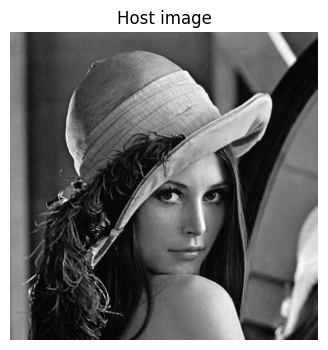

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


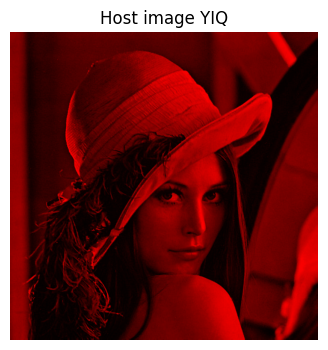

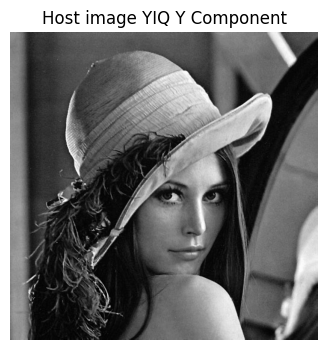

In [5]:
# Convert to YIQ color space

host_image_yiq = rgb_to_yiq(host_image / 255.0)

# Extract Y component (luminance)
host_image_yiq_y_comp = host_image_yiq[:, :, 0]
host_image_yiq_y_comp

show_image(host_image, "Host image")
show_image(host_image_yiq, "Host image YIQ")
show_image(host_image_yiq_y_comp, "Host image YIQ Y Component")

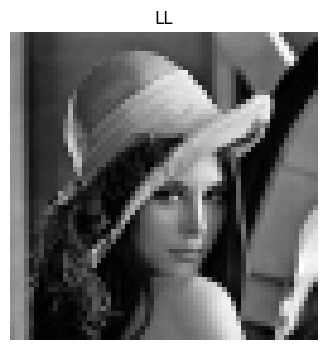

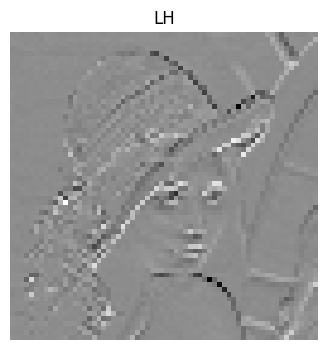

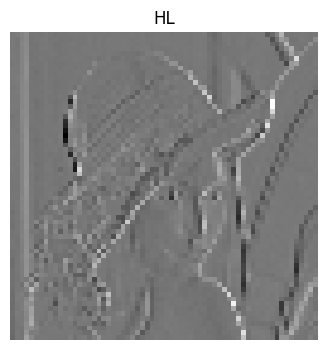

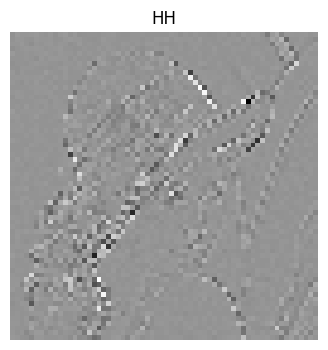

In [6]:
# Apply 3 Level DWT to Y component of YIQ Host Image

coeffs = pywt.wavedec2(host_image_yiq[:, :, 0], 'haar', level=3)
cA, (cH, cV, cD) = coeffs = coeffs[0], coeffs[1]

res = [cA, cH, cV, cD]
labels = ['LL', 'LH', 'HL', 'HH']
for i in range(len(res)):
    show_image(res[i], labels[i])

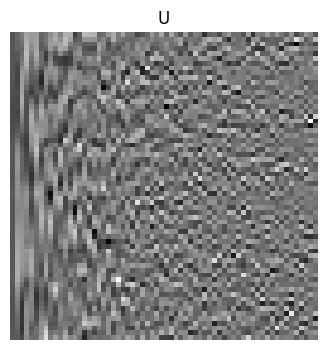

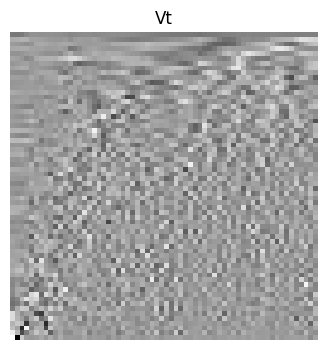

In [7]:
#Applying SVD on YIQ Host Image

U, S, Vt = apply_svd(cA)

show_image(U, "U")
show_image(Vt, "Vt")

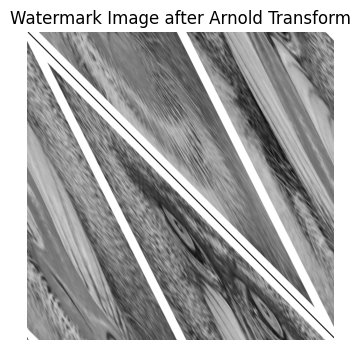

In [8]:
# Applying Arnold Transformationg on Watermark Image

def arnold_transform(image, iterations):
    # Get image dimensions
    height, width = image.shape[:2]

    # Perform Arnold transformation
    for index in range(iterations):
        new_image = np.zeros_like(image)
        for y in range(height):
            for x in range(width):
                new_x = (1 * x + 1 * y) % width
                new_y = (1 * x + 2 * y) % height
                new_image[new_y, new_x] = image[y, x]
        image = new_image
        # if(index % 5 == 0) :
        #     show_image(image, f'Iterations: {index+1}')

    return image

arnold_transformed_image = arnold_transform(watermark_image, 1)
show_image(arnold_transformed_image, "Watermark Image after Arnold Transform")

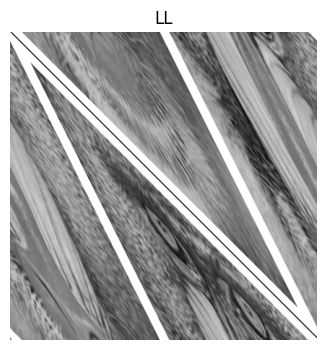

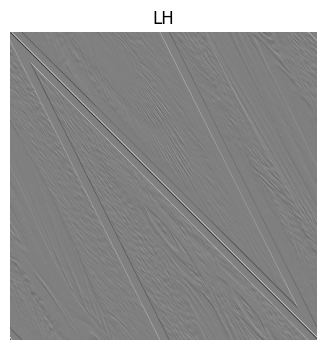

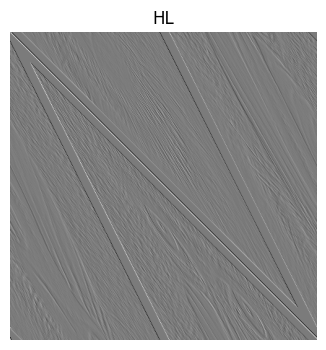

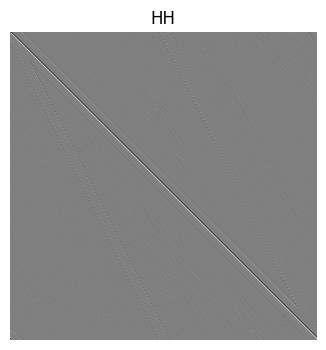

In [9]:
# Apply 1 Level DWT to Y component of Watermark Image after Arnold Transformation

arnold_y = rgb_to_yiq(arnold_transformed_image / 255.0)

coeffs_W = pywt.wavedec2(watermark_image[:, :, 0] if 0 else arnold_y[:, :, 0], 'haar', level=1)
cA_W, (cH_W, cV_W, cD_W) = coeffs_W = coeffs_W[0], coeffs_W[1]

res_w = [cA_W, cH_W, cV_W, cD_W]
labels = ['LL', 'LH', 'HL', 'HH']
res
for i in range(len(res_w)):
    show_image(res_w[i], labels[i])

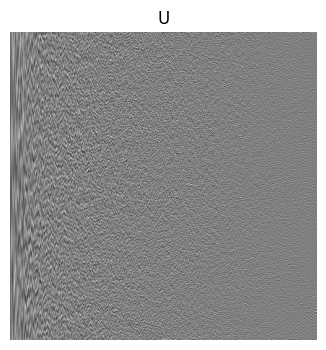

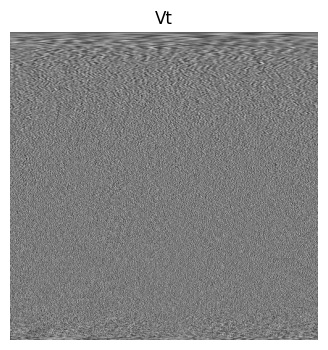

In [10]:
Uw , Sw , VtW = apply_svd(cA_W) 

show_image(Uw, "U")
show_image(VtW, "Vt")

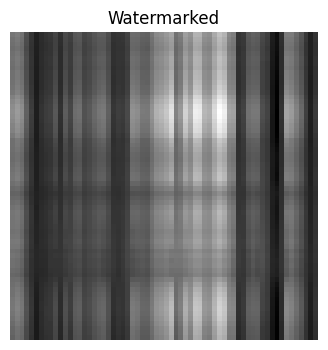

In [11]:
watermarked_cA = watermark_embedding(U, S, Vt, Sw, 0.5)

show_image(watermarked_cA, "Watermarked")